In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **데이터 살펴보기**

In [ ]:
!pip install nltk

In [ ]:
import pandas as pd
import warnings 
warnings.filterwarnings(action='ignore')
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re

from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
#경로 설정
import os
os.chdir('/content/drive/My Drive/dacon_nlp')

In [ ]:
#파일 불러오기
train = pd.read_csv('open/train.csv', encoding = 'utf-8')
test = pd.read_csv('open/test_x.csv', encoding = 'utf-8')
sample_submission = pd.read_csv('open/sample_submission.csv', encoding = 'utf-8')

In [ ]:
#train 데이터 살펴보기
train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [ ]:
#test 데이터 살펴보기
test

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...
...,...,...
19612,19612,"At the end of another day or two, odin growing..."
19613,19613,"All afternoon we sat together, mostly in silen..."
19614,19614,"odin, having carried his thanks to odin, proc..."
19615,19615,"Soon after this, upon odin's leaving the room,..."


In [ ]:
#sample_submission
sample_submission

,index,0,1,2,3,4
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,2,0,0,0,0,0
3,3,0,0,0,0,0
4,4,0,0,0,0,0
...,...,...,...,...,...,...
19612,19612,0,0,0,0,0
19613,19613,0,0,0,0,0
19614,19614,0,0,0,0,0
19615,19615,0,0,0,0,0


# **전처리**

## 특수문자 제거

In [ ]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

def clean_text(text):
    text = re.sub(r'[^A-Za-z0-9 ]', '', text)
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(ps.stem(i.strip()))
    return " ".join(final_text)

In [ ]:
import nltk
nltk.download('stopwords')
print(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'bo

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')

In [ ]:
#전처리 적용
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(clean_text)
test['text'] = test['text'].apply(clean_text)

In [ ]:
# train test 분리
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
y_train = np.array([x for x in train['author']])

In [ ]:
X_train

array(['almost choke much much want say strang exclam came lip pole gaze fixedli bundl note hand look odin evid perplex',
       'sister ask suppos',
       'engag one day walk perus jane last letter dwell passag prove jane written spirit instead surpris mr odin saw look odin meet put away letter immedi forc smile said',
       ..., 'sincer wellwish friend sister luci odin', 'want lend money',
       'certainli occur said ye like'], dtype='<U1310')

리뷰의 최대 길이 : 1310
리뷰의 평균 길이 : 117.11332203575138


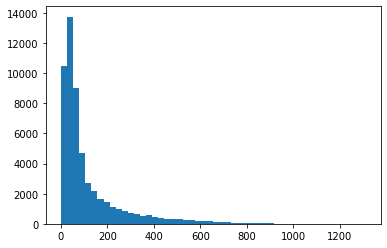

In [ ]:
from matplotlib import pyplot as plt

print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.show()

## 토큰화

In [ ]:
# Tokenizer -> fit -> word index -> text to sequence -> pad sequence

In [ ]:
#파라미터 설정
vocab_size = 20000
embedding_dim = 64
max_length = 200
padding_type='post'
oov_tok = "<OOV>"

In [ ]:
#tokenizer에 fit (정수인코딩)
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [ ]:
#데이터를 sequence로 변환해주고 padding
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

# **모델링**

## 신경망

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [ ]:
#가벼운 NLP모델 생성
lstm_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(lstm_dim,dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
# compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 64)           1280000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               49920     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 1,338,501
Trainable params: 1,338,501
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# fit model
num_epochs = 10
batch_size = 128
history = model.fit(train_padded, y_train,batch_size=batch_size,
                    epochs=num_epochs, verbose=2, callbacks=[es,mc],validation_split=0.2)

Epoch 1/10
343/343 - 493s - loss: 1.2644 - accuracy: 0.4695 - val_loss: 1.0219 - val_accuracy: 0.5902
Epoch 2/10
343/343 - 491s - loss: 0.9171 - accuracy: 0.6408 - val_loss: 0.8636 - val_accuracy: 0.6634
Epoch 3/10
343/343 - 466s - loss: 0.7568 - accuracy: 0.7114 - val_loss: 0.7860 - val_accuracy: 0.6989
Epoch 4/10
343/343 - 440s - loss: 0.6635 - accuracy: 0.7515 - val_loss: 0.7506 - val_accuracy: 0.7196
Epoch 5/10
343/343 - 438s - loss: 0.6038 - accuracy: 0.7753 - val_loss: 0.7173 - val_accuracy: 0.7321
Epoch 6/10
343/343 - 435s - loss: 0.5600 - accuracy: 0.7925 - val_loss: 0.7131 - val_accuracy: 0.7330
Epoch 7/10
343/343 - 436s - loss: 0.5272 - accuracy: 0.8044 - val_loss: 0.7051 - val_accuracy: 0.7383
Epoch 8/10
343/343 - 437s - loss: 0.5015 - accuracy: 0.8145 - val_loss: 0.7197 - val_accuracy: 0.7395
Epoch 9/10
343/343 - 436s - loss: 0.4791 - accuracy: 0.8236 - val_loss: 0.7107 - val_accuracy: 0.7423
Epoch 10/10
343/343 - 435s - loss: 0.4610 - accuracy: 0.8311 - val_loss: 0.7320 - 

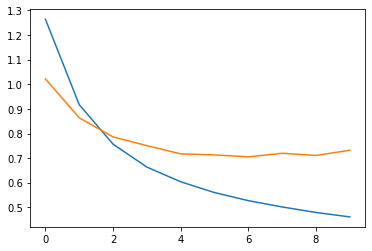

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.show()

# submission

In [ ]:
model_best = tf.keras.models.load_model('/content/drive/My Drive/dacon_nlp/best_model.h5')

In [ ]:
# predict values
pred = model_best.predict_proba(test_padded)

Instructions for updating:
Please use `model.predict()` instead.


In [ ]:
pred

array([[9.5188236e-03, 7.5101614e-02, 9.0817517e-01, 5.4299529e-03,
        1.7744743e-03],
       [3.7953842e-01, 3.3196014e-01, 2.7212180e-02, 2.2752538e-02,
        2.3853676e-01],
       [9.9910372e-01, 5.3893257e-04, 1.3927357e-04, 1.1645339e-05,
        2.0638159e-04],
       ...,
       [5.4350786e-04, 9.9902749e-01, 1.8115254e-04, 2.2486520e-04,
        2.2965207e-05],
       [3.5297105e-04, 9.9958175e-01, 3.1901298e-05, 2.8505248e-05,
        4.8804227e-06],
       [9.9904042e-01, 2.7336416e-04, 3.1584845e-04, 4.8912170e-05,
        3.2144712e-04]], dtype=float32)

In [ ]:
# submission
sample_submission[['0','1','2','3','4']] = pred
sample_submission

,index,0,1,2,3,4
0,0,0.009519,0.075102,0.908175,0.005430,0.001774
1,1,0.379538,0.331960,0.027212,0.022753,0.238537
2,2,0.999104,0.000539,0.000139,0.000012,0.000206
3,3,0.000285,0.002022,0.996634,0.000600,0.000459
4,4,0.487153,0.012692,0.013145,0.262229,0.224781
...,...,...,...,...,...,...
19612,19612,0.000159,0.999800,0.000016,0.000023,0.000003
19613,19613,0.016980,0.000167,0.006451,0.000122,0.976279
19614,19614,0.000544,0.999027,0.000181,0.000225,0.000023
19615,19615,0.000353,0.999582,0.000032,0.000029,0.000005


In [ ]:
sample_submission.to_csv('submission.csv', index = False)